In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
df_external = pd.read_csv('external/external.csv')
df_external.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [7]:
highest_ratio = df['Target'].value_counts()[df['Target'].value_counts()>1000].index.tolist()

In [8]:
highest_ratio

['0', '25 0', '23', '25', '7', '4', '21']

In [9]:
df_external = df_external[~df_external['Target'].isin(highest_ratio)]

In [10]:
len(df_external)

36291

In [11]:
df_complete = df.append(df_external).reset_index(drop=True)

In [12]:
#df_complete = df_full.sample(frac=0.5).reset_index(drop=True, inplace=True)

In [13]:
len(df), len(df_external), len(df_complete)

(31072, 36291, 67363)

### get better validation split since the classes are very unevenly represented

In [14]:
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [15]:
def plot_ratio(targets):
    labels_num = [value.split() for value in targets]
    labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
    labels = ["" for _ in range(len(labels_num_flat))]
    for i in range(len(labels_num_flat)):
        labels[i] = subcell_locs[labels_num_flat[i]]

    fig, ax = plt.subplots(figsize=(15, 5))
    pd.Series(labels).value_counts().plot('bar', fontsize=14)

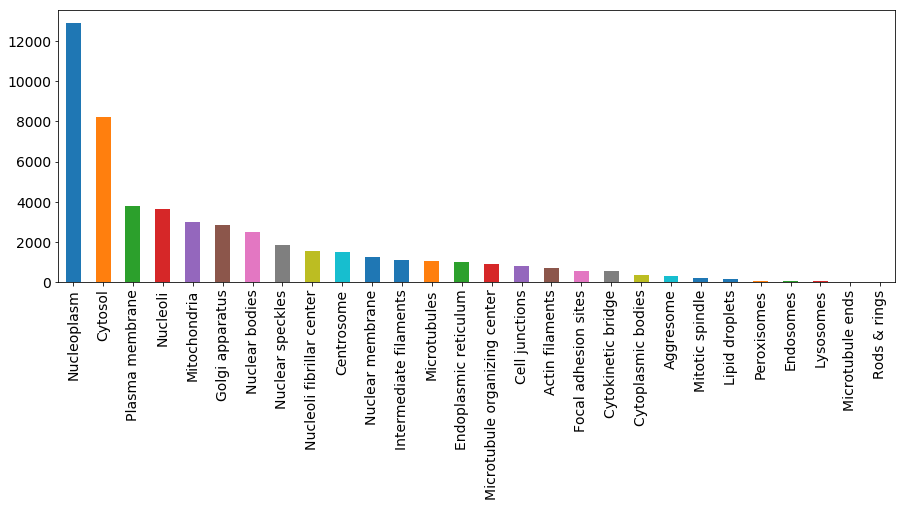

In [16]:
plot_ratio(df['Target'])

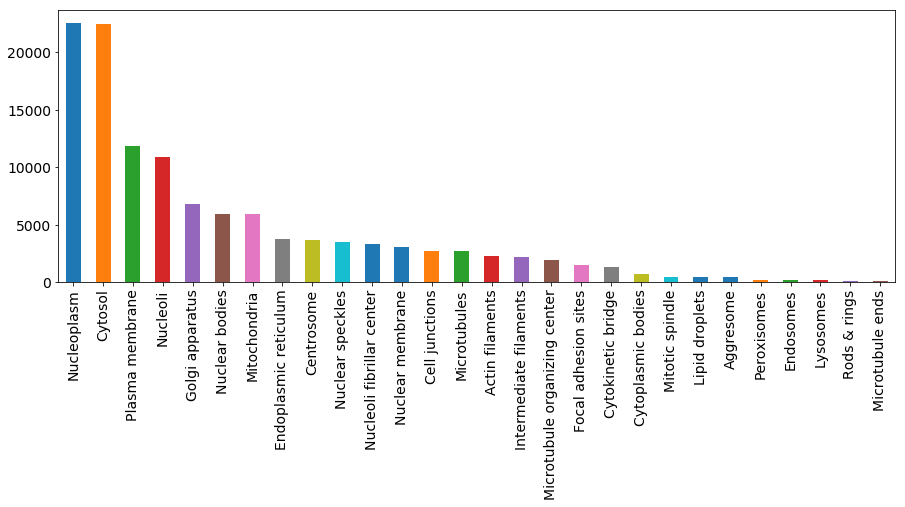

In [17]:
plot_ratio(df_complete['Target'])

In [18]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) #random_state=42
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

#del X, y
gc.collect()

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


2

In [19]:
train_index = np.append(train_index, [i for i in range(len(df), len(df_complete))])
len(train_index), len(val_index), len(df_complete)

(64249, 3114, 67363)

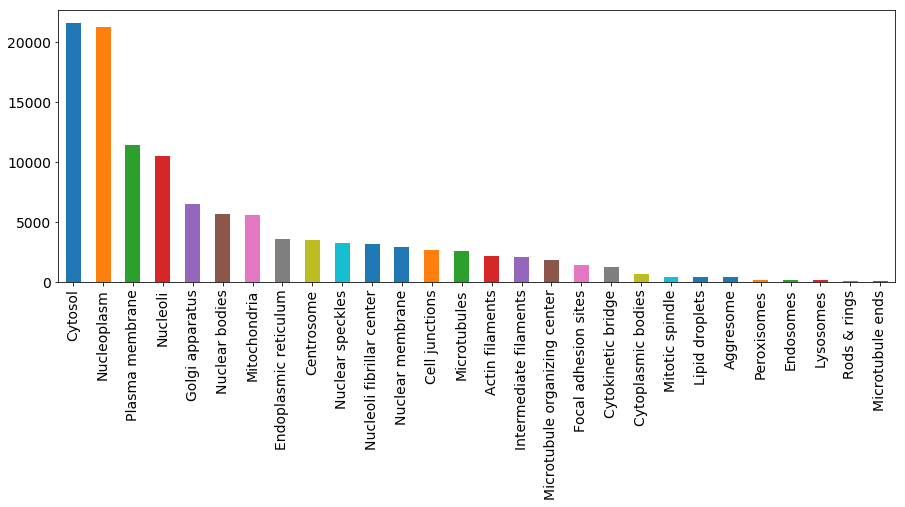

In [20]:
plot_ratio(df_complete.loc[train_index]['Target'])

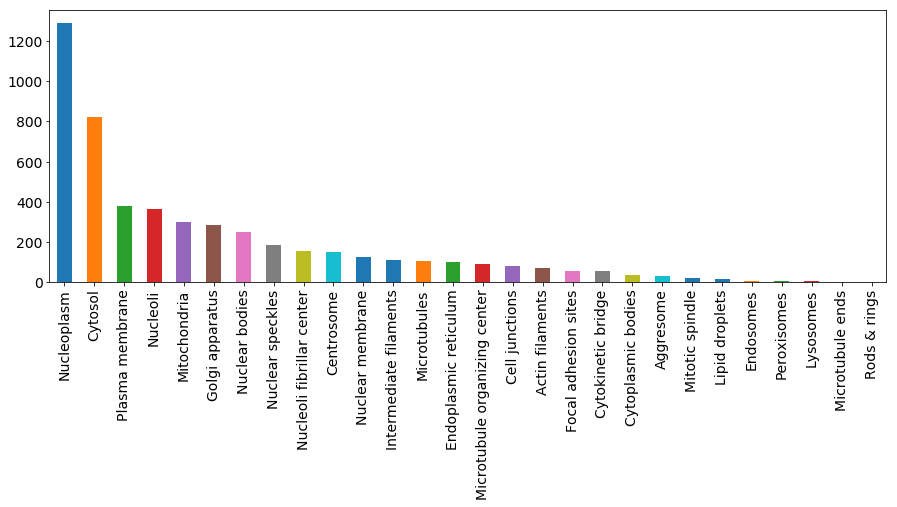

In [21]:
plot_ratio(df_complete.loc[val_index]['Target'])

### set everything we need for creating a ImageMultiDataset

In [22]:
fns = pd.Series([id + '.png' for id in df_complete.Id])
labels = [targ.split(' ') for targ in df_complete.Target]
classes=[str(i) for i in range(28)]

In [23]:
trn_mask=[]

for i in range(len(df_complete)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(67363, 64249, 3114)

### create train, valid and test ImageMultiDataset

In [24]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 64249, ImageMulti4Channel of len 3114)

In [25]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [26]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### Calculate mean/std for this dataset

In [27]:
#means = torch.zeros(4)
#stds = torch.zeros(4)

In [28]:
#count_all = len(fns) + len(test_ids)

In [29]:
#colors = ['red','green','blue','yellow']
#
#for fname in fns:
#    channels = [open_image('data/train/'+fname[:-4]+'_'+color+'.png', convert_mode='L').data for color in colors]
#    
#    stack = np.stack(channels, axis=-1)
#    img = Image(pil2tensor(stack[0,:,:], np.float32).float()).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])
#
#for fname in test_ids:
#    channels = [open_image('data/test/'+fname+'_'+color+'.png', convert_mode='L').data for color in colors]
#    
#    stack = np.stack(channels, axis=-1)
#    img = Image(pil2tensor(stack[0,:,:], np.float32).float()).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])
#    
#means /= count_all
#stds /= count_all

In [30]:
#means, stds

### define transforms, normalization and metric

In [31]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [32]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
#                      max_lighting=0.2, max_warp=0.2)

In [33]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.,
                      max_lighting=0.2, max_warp=0.)

In [34]:
#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

stats_external = ([0.0574, 0.0478, 0.0311, 0.0848], [0.0899, 0.0748, 0.0793, 0.1265]) #should be good

### create ImageDataBunch from all this

In [35]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [36]:
bs = 48

In [37]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(stats_external)

In [38]:
data.train_ds, data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 64249),
 DatasetTfm(ImageMulti4Channel of len 3114))

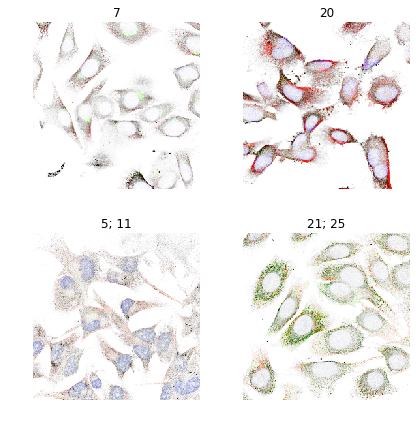

In [39]:
data.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

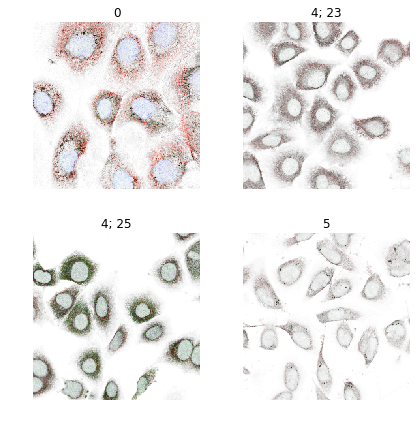

In [40]:
data.show_batch(rows=2, figsize=(6,6))

### create model and learner

In [41]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

def resnet101(pretrained=True):
    return Resnet4Channel(encoder_depth=101, pretrained=pretrained)

def resnet152(pretrained=True):
    return Resnet4Channel(encoder_depth=152, pretrained=pretrained)

In [42]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [43]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [44]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [45]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [46]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [47]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [48]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2): #gamma=4 working pretty bad
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [49]:
learn = create_cnn(
    data,
    resnet50,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [50]:
learn.loss_func = FocalLoss()

In [51]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [52]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [53]:
learn.freeze()

In [54]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [55]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 64249),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [56]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


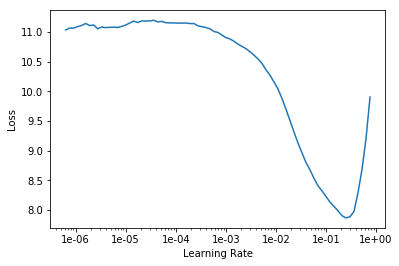

In [57]:
learn.recorder.plot() #including externalmix  0.1 valid

In [58]:
lr = 1e-3

### fit the model (half image size)

Total time: 08:27
epoch  train_loss  valid_loss  fbeta  acc        
1      1.245608    1.057078    0.465159  0.951899  (08:26)



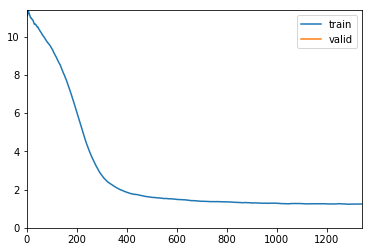

In [59]:
learn.fit_one_cycle(1, max_lr=slice(lr)) # zoom 1.0 external norm_stats 

In [60]:
learn.save('halfsz_res50_frozen')

### unfreeze there resnet layers and train again 

In [48]:
learn.load('halfsz_res50_frozen')

In [61]:
learn.unfreeze()

In [62]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


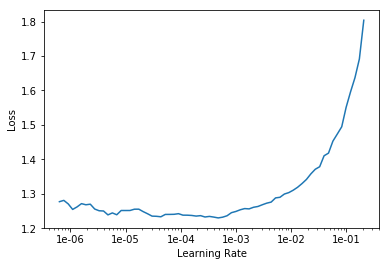

In [63]:
learn.recorder.plot() #resnet50 zoom 1.0 external norm_stats

In [64]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [65]:
#lrs = slice(1e-5, 1e-4) 
lr = 3e-4
lrs = slice(lr/2, lr) 

In [66]:
learn.lr_range(lrs)

array([0.00015 , 0.000212, 0.0003  ])

Total time: 3:53:57
epoch  train_loss  valid_loss  fbeta  acc        
1      1.080377    0.882560    0.577455  0.958987  (10:10)
2      0.972316    0.794473    0.642844  0.963483  (10:58)
3      0.933115    0.766182    0.648947  0.964997  (10:55)
4      0.898787    0.765303    0.648246  0.964160  (10:58)
5      0.894416    0.771722    0.648680  0.963712  (10:03)
6      0.861563    0.756460    0.660621  0.963953  (09:59)
7      0.851718    0.714488    0.683391  0.966270  (10:00)
8      0.859948    0.709304    0.681449  0.966029  (09:59)
9      0.838031    0.670570    0.699982  0.968105  (09:59)
10     0.782220    0.635259    0.713972  0.969860  (10:30)
11     0.757069    0.652510    0.717260  0.970032  (10:48)
12     0.772403    0.600558    0.731583  0.971362  (10:49)
13     0.732542    0.592215    0.738047  0.971626  (10:40)
14     0.710427    0.563644    0.747717  0.972440  (11:10)
15     0.679891    0.564148    0.753549  0.972497  (10:34)
16     0.655872    0.548154    0.761996  0.97

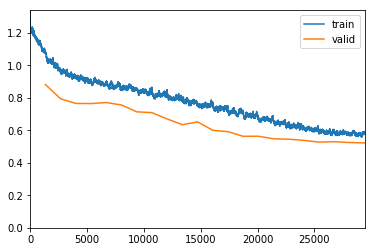

In [67]:
learn.fit_one_cycle(22, max_lr=lrs) # zoom 1.0 external norm_stats

In [68]:
learn.save('halfsz_res50_unfrozen')

Total time: 3:40:23
epoch  train_loss  valid_loss  fbeta  acc        
1      1.112442    0.907410    0.566975  0.958058  (10:06)
2      0.986490    0.809911    0.627593  0.962026  (10:01)
3      0.930215    0.766158    0.653624  0.964790  (09:59)
4      0.916879    0.734358    0.665079  0.965260  (10:30)
5      0.886184    0.735785    0.669559  0.965456  (09:59)
6      0.872526    0.741241    0.665941  0.964698  (09:55)
7      0.854458    0.731789    0.676044  0.965490  (09:58)
8      0.827704    0.686628    0.695718  0.966476  (09:58)
9      0.805927    0.656304    0.708614  0.968610  (09:58)
10     0.798098    0.629423    0.721472  0.969561  (09:58)
11     0.765813    0.618302    0.730590  0.969905  (09:56)
12     0.731161    0.596447    0.736848  0.971110  (09:58)
13     0.721642    0.586599    0.743840  0.971431  (09:59)
14     0.703442    0.593269    0.735224  0.971488  (09:58)
15     0.679111    0.563756    0.747900  0.972555  (09:56)
16     0.657994    0.546733    0.760313  0.97

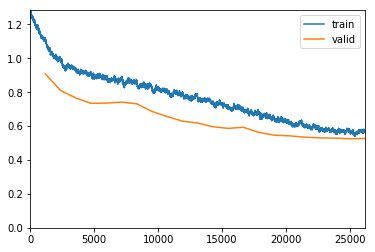

In [53]:
learn.fit_one_cycle(22, max_lr=lrs) # zoom 1.0 external norm_stats

### train on whole picture (512px)

In [49]:
bs = 14

In [50]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(stats_external)

In [51]:
learn = create_cnn(
    data,
    resnet50,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [52]:
learn.loss_func = FocalLoss()

In [53]:
learn.split(split_on=_resnet_split)

In [54]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [55]:
learn.load('pog_halfsz')

In [55]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


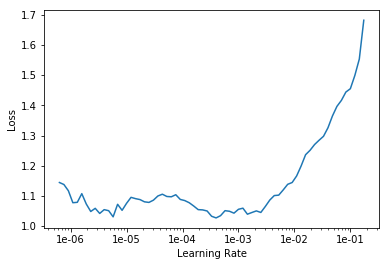

In [58]:
learn.recorder.plot() #zoom 1.0 external norm_stats

In [59]:
learn.callback_fns.append(partial(SaveModel, every='epoch', monitor='val_loss'))

In [72]:
lr = 5e-5

lrs = slice(lr/2, lr)

In [73]:
learn.lr_range(lrs)

array([2.500000e-05, 3.535534e-05, 5.000000e-05])

Total time: 13:13:11
epoch  train_loss  valid_loss  fbeta  acc        
1      0.773638    0.578668    0.741883  0.972555  (38:42)
2      0.726395    0.544482    0.765156  0.973920  (38:32)
3      0.698088    0.547765    0.765345  0.974596  (38:34)
4      0.729725    0.520295    0.770272  0.974940  (38:35)
5      0.687055    0.533407    0.770568  0.974642  (38:36)
6      0.715829    0.537105    0.765400  0.975032  (38:37)
7      0.682547    0.555751    0.755238  0.973817  (38:37)
8      0.669416    0.541632    0.774907  0.974172  (38:38)
9      0.669623    0.514944    0.775853  0.975307  (38:36)
10     0.651485    0.518639    0.777651  0.975514  (38:36)
11     0.634407    0.509765    0.783544  0.975755  (38:38)
12     0.635411    0.510596    0.783220  0.976133  (38:39)
13     0.580348    0.511086    0.782272  0.976133  (41:13)
14     0.563865    0.502752    0.786648  0.976271  (40:39)
15     0.583895    0.508140    0.791320  0.976409  (42:46)
16     0.557824    0.511036    0.789570  0.9

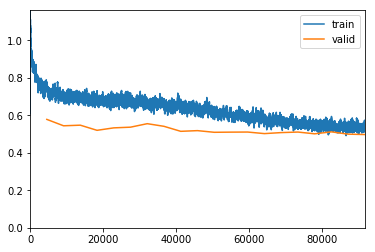

In [74]:
learn.fit_one_cycle(20, lrs, div_factor=10) #5e-5 slice(lr/2, lr/1) resnet50 externalmix 0.1 valid

In [75]:
learn.save('fullsz_res50_unfrozen')

## try to improve best model 

In [57]:
learn.load('fullsz_res50_unfrozen')

In [56]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


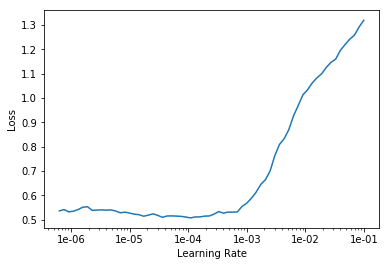

In [58]:
learn.recorder.plot() 

In [59]:
lr = 2e-5

lrs = slice(lr/2, lr)
learn.lr_range(lrs)

array([1.000000e-05, 1.414214e-05, 2.000000e-05])

epoch,train_loss,valid_loss,fbeta,acc
1,0.538705,0.513080,0.790917,0.976752
2,0.556519,0.523105,0.788648,0.976385


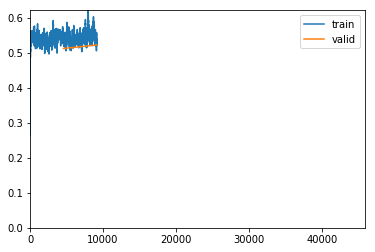

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offs

KeyboardInterrupt: 

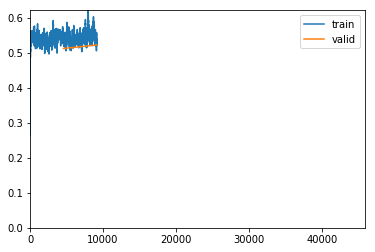

In [60]:
learn.fit_one_cycle(10, lrs, div_factor=10) #1e-4 slice(lr/2, lr/1) same split

In [55]:
learn.save('fullsz_res50_unfrozen_improve')

In [56]:
#todo export conda env and import it in google cloud compute



### Try to find a good Threshold

In [56]:
#learn.load('best/bestmodel_externalres50')
learn.load('with_external/res50mix/fullsz_res50_unfrozen')

In [57]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [60]:
#preds, y = learn.get_preds(DatasetType.Valid)

In [58]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:45



In [60]:
#act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [61]:
#ensamble = act_preds * 0.1 + act_preds_tta * 0.9

In [62]:
#np.set_printoptions(suppress=True)

In [64]:
weights = np.array([0.5000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000,
                    0.2000, 0.2000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000, 0.4000, 0.4000,
                    0.4000, 0.4000, 0.2000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000])

In [65]:
weights

array([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

### optimize with sklearn

In [66]:
#fb = partial(fbeta, ensamble, y, sigmoid=False)

In [67]:
from scipy.optimize import minimize, fmin
import sklearn.metrics as m

In [68]:
def f1_thresh_negative(thresh):
    return -m.f1_score((act_preds_tta.numpy()>thresh), y.numpy(), average='macro')

def f1_thresh(thresh):
    return m.f1_score((act_preds_tta.numpy()>thresh), y.numpy(), average='macro')

In [181]:
def fbeta_thresh(thresh):
    return -fbeta(act_preds_tta, y, thresh=torch.from_numpy(thresh).float(), sigmoid=False).numpy()

In [ ]:
#optimize on macro f1

In [69]:
thresh = fmin(f1_thresh_negative, weights, maxiter=1000, maxfun=2000, xtol=1e-10, ftol=1e-10)

/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Optimization terminated successfully.
         Current function value: -0.701289
         Iterations: 303
         Function evaluations: 1209


In [161]:
res = minimize(f1_thresh_negative, weights, method='Powell',
               options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.755639
         Iterations: 4
         Function evaluations: 3813


In [ ]:
#optimize on fbeta fastai function (works worse)

In [185]:
#thresh = fmin(fbeta_thresh, weights, maxiter=1000, maxfun=2000, xtol=1e-10, ftol=1e-10)

Optimization terminated successfully.
         Current function value: -0.816679
         Iterations: 327
         Function evaluations: 1254


In [186]:
#res = minimize(fbeta_thresh, weights, method='Powell',
#               options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.838951
         Iterations: 4
         Function evaluations: 3985


In [162]:
#from numdifftools import Jacobian, Hessian

In [163]:
#def fun_jac(x):
#    return Jacobian(lambda x: f1_thresh_negative(x))(x).ravel()
#
#def fun_hess(x):
#    return Hessian(lambda x: f1_thresh_negative(x))(x)

In [309]:
#res = minimize(f1_thresh_negative, weights, method='BFGS', jac = fun_jac,
#               options={'disp': True})

In [187]:
res.x

array([ 0.36634 ,  0.4     ,  0.349465,  0.283904,  0.364906,  0.307187,  0.340483,  0.396411,  0.2     ,  0.511202,
        0.438344,  0.263827,  0.370664,  0.244668,  0.257873,  0.176309,  0.342251,  0.21975 ,  0.284464,  0.286801,
        0.365188,  0.332655,  0.414703,  0.266312,  0.428324,  0.340259,  0.4     , 10.551716])

In [188]:
thresh = res.x

In [189]:
thresh[-1]=0.3

In [230]:
thresh

array([0.36634 , 0.4     , 0.349465, 0.283904, 0.364906, 0.307187, 0.340483, 0.396411, 0.2     , 0.511202, 0.438344,
       0.263827, 0.370664, 0.244668, 0.257873, 0.176309, 0.342251, 0.21975 , 0.284464, 0.286801, 0.365188, 0.332655,
       0.414703, 0.266312, 0.428324, 0.340259, 0.4     , 0.3     ])

In [256]:
fbeta(act_preds_tta, y, thresh=torch.from_numpy(thresh).float(), sigmoid=False)

tensor(0.8390)

In [193]:
f1_thresh(thresh)

/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.7373305329064895

### predict test set 

In [77]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [78]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 18:42



In [232]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [233]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [234]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [237]:
#tuned_weights = (weights*0.85).numpy()
tuned_weights = thresh * 0.9 #0.845
tuned_weights

array([0.329706, 0.36    , 0.314519, 0.255514, 0.328415, 0.276469, 0.306435, 0.35677 , 0.18    , 0.460082, 0.394509,
       0.237444, 0.333598, 0.220201, 0.232086, 0.158678, 0.308026, 0.197775, 0.256017, 0.258121, 0.328669, 0.299389,
       0.373233, 0.239681, 0.385492, 0.306233, 0.36    , 0.27    ])

In [238]:
#ensamble_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9

In [239]:
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.327)[0]])) \
#               for row in np.array(ensamble_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>tuned_weights)[0]])) \
               for row in np.array(act_preds_t_tta)]

### replace empty predicitons with highest probability

In [243]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [244]:
for ind in indices: 
    pred_labels[ind] = \
    ' '.join(list([str(i) for i in np.nonzero(act_preds_t_tta[ind].numpy()>tuned_weights*0.9)[0]]))
    #print(pred_labels[ind])

In [247]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [248]:
for ind in indices:
    act_preds_t_tta[ind]
    _max = torch.max(act_preds_t_tta[ind])
    argmax = ((act_preds_t_tta[ind] == _max).nonzero())
    pred_labels[ind] = str(argmax.numpy()[0][0])

### create submission and replace the leaked prediction for leaderboard comparison

In [249]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [250]:
len(sub['Predicted'][sub['Predicted']==''])

0

In [251]:
#test_matches = pd.read_csv(path/'test_matches.csv')

In [252]:
#test_matches.head()

In [253]:
#for _, row in test_matches.iterrows():
#    print(sub[sub.Id == row.Test].Predicted)
#    sub['Predicted'][sub.Id == row.Test] = row.Target
#    print(sub[sub.Id == row.Test].Predicted)

## public lb f1 scores:

### using with_external/best/bestmodel_externalres50_4E 

### with leak

- 0.579 

### without leak

- 0.554 filling nulls

- 0.557 not filling nulls thresh * 0.845 (best val thresh)

- 0.555 not filling nulls thresh * 0.9

- 0.558 not filling nulls thresh * 0.8

In [254]:
sub.to_csv(path/'resnet50.csv', header=True, index=False)

In [255]:
pred_labels

['2',
 '0 5 25',
 '0 5 25',
 '0 25',
 '2 23 25',
 '4 25',
 '0 4 21 25',
 '0 23 25',
 '0',
 '4 21 25',
 '7 18 25',
 '3 5',
 '2 25',
 '7 21 25',
 '18 23 25',
 '2 17 18 23 25',
 '2 25',
 '0 5',
 '4 14 21',
 '0 5',
 '1 6 25',
 '2 5 23 25',
 '0 11 18 25',
 '0 21',
 '0 4',
 '0 12 21 23 25',
 '0 21 23',
 '0',
 '0 25',
 '0 5',
 '0 2 13 21',
 '0 7 18 19 21 25',
 '14 17 18 25',
 '5 25',
 '0 7 25',
 '13',
 '0 19 25',
 '0 3',
 '5 21 25',
 '0 1',
 '0 23 25',
 '6 25',
 '0 18 21 25',
 '19 25',
 '18 21 25',
 '6 20 25',
 '0',
 '0 18 21',
 '0 6 25',
 '0',
 '0 19 25',
 '0 5',
 '7 23',
 '0 25',
 '3',
 '0 23 25',
 '0 25',
 '11',
 '0 21 25',
 '0 21 25',
 '2',
 '0 5 21',
 '14 21 25',
 '0 5 21 25',
 '7 23 25',
 '0 21 25',
 '3 6 21 25',
 '25',
 '0 16 17 25',
 '11 25',
 '2 3',
 '0 2 25',
 '14',
 '4',
 '21',
 '0',
 '0 4',
 '0 1 21 25',
 '0 25',
 '0 25',
 '25 26',
 '0 25',
 '0 5 21 25',
 '2 21 25',
 '18 19',
 '0 25',
 '18 23',
 '0 21',
 '25',
 '11 14 21 25',
 '0 25',
 '11',
 '23',
 '11 13',
 '23 25',
 '0 25',
 '1